# Spline Constraints Demo
This notebook demonstrates how constraints can be applied to different splines using the `lpspline` package.


In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from lpspline.spline import Linear, PiecewiseLinear, BSpline
from lpspline.constraints import Anchor, Monotonic, Concave, Convex
from lpspline.optimizer import LpRegressor

# Create a sample dataset
np.random.seed(50)
x_data = np.linspace(-5, 5, 200)
# A somewhat wavy relationship
y_data = np.sin(x_data) + np.random.normal(0, 0.2, 200)

df = pl.DataFrame({"x": x_data, "y": y_data})

def plot_fit(opt, title=""):
    opt.fit(df, df["y"])
    y_pred = opt.predict(df)
    
    plt.figure(figsize=(8, 4))
    plt.scatter(df["x"], df["y"], alpha=0.3, label="Data")
    plt.plot(df["x"], y_pred, color='red', linewidth=2, label="Fit")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## 1. Anchor Constraint
The `Anchor` constraint forces a spline to pass through specific `(x, y)` points.


Unconstrained PWL:

✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------------------------------------
Spline Type               | Term            | Params   | Constraints                   
--------------------------------------------------------------------------------
🟢 PiecewiseLinear        | x               | 5        | None                          
--------------------------------------------------------------------------------
📊 Total Parameters                         | 5        |



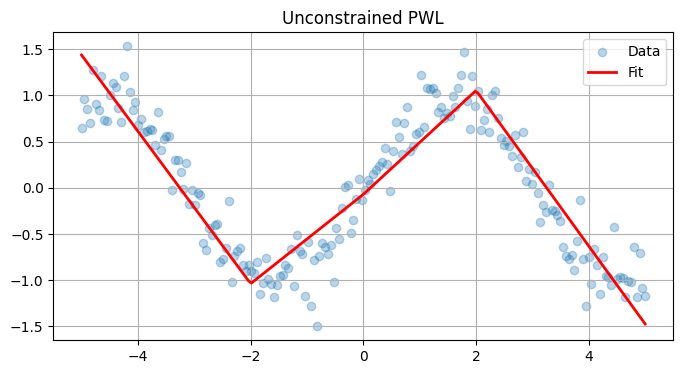

Anchored PWL (at x=-2, y=2 and x=2, y=-2):

✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------------------------------------
Spline Type               | Term            | Params   | Constraints                   
--------------------------------------------------------------------------------
🟢 PiecewiseLinear        | x               | 5        | Anchor                        
--------------------------------------------------------------------------------
📊 Total Parameters                         | 5        |



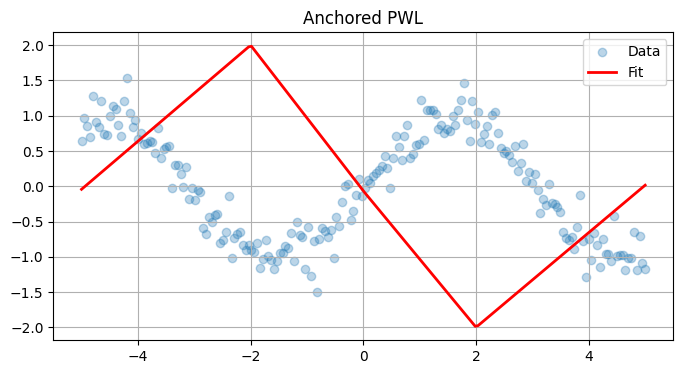

In [2]:
# We'll use a Piecewise Linear spline and anchor it at (-2, 2) and (2, -2).
pwl = PiecewiseLinear("x", knots=[-2, 0, 2])

# Unconstrained
print("Unconstrained PWL:")
opt_unconstrained = LpRegressor(pwl)
plot_fit(opt_unconstrained, "Unconstrained PWL")

# Constrained
print("Anchored PWL (at x=-2, y=2 and x=2, y=-2):")
pwl_anchored = PiecewiseLinear("x", knots=[-2, 0, 2])
pwl_anchored.add_constraint(Anchor([(-2, 2), (2, -2)]))

opt_anchored = LpRegressor(pwl_anchored)
plot_fit(opt_anchored, "Anchored PWL")


## 2. Monotonic Constraint
The `Monotonic` constraint forces a spline to be monotonically increasing (or decreasing). Here we apply it to a `BSpline`.


Unconstrained B-Spline:

✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------------------------------------
Spline Type               | Term            | Params   | Constraints                   
--------------------------------------------------------------------------------
🟢 BSpline                | x               | 22       | None                          
--------------------------------------------------------------------------------
📊 Total Parameters                         | 22       |



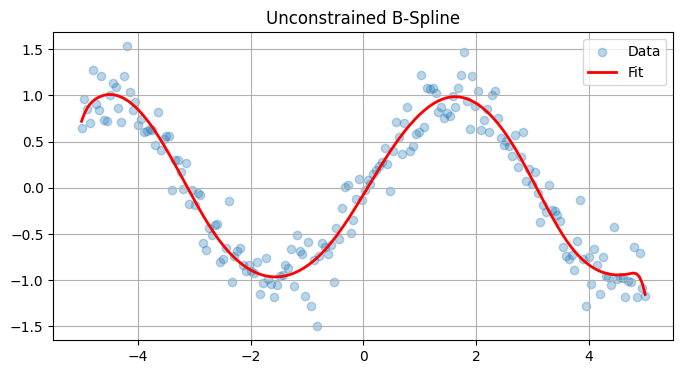

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -3.85824566e+01 -2.30933588e-02  1.26671327e+00  7.55410923e-01
 -6.69299404e-01 -1.10470900e+00 -6.99111017e-01  5.40075642e-01
  1.17971139e+00  6.50736984e-01 -8.62295115e-01 -1.03191883e+00
 -5.81357103e-01 -1.07099842e+02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


In [3]:
bsp = BSpline("x", knots=np.linspace(-10, 10, 20), degree=3, tag='bs')

# Unconstrained
print("Unconstrained B-Spline:")
opt_unconstrained = LpRegressor(bsp)
plot_fit(opt_unconstrained, "Unconstrained B-Spline")

print(opt_unconstrained.get_spline('bs').coefficients)

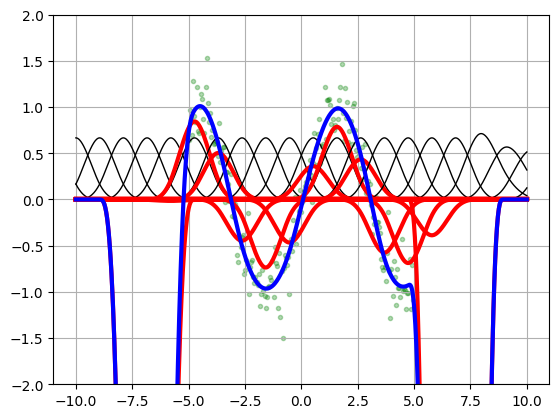

In [4]:
xx = np.linspace(-10, 10, 1000).reshape(-1, 1)
basis = opt_unconstrained.get_spline('bs')._build_basis(xx)
evalbasis = opt_unconstrained.get_spline('bs').eval(xx, return_basis=True)
evalspline = opt_unconstrained.get_spline('bs').eval(xx, return_basis=False)

for i in range(basis.shape[1]):
    plt.plot(xx, basis[:, i], color='k', linewidth=1)
    plt.plot(xx, evalbasis[:, i], color='r', linewidth=3)
plt.scatter(df['x'], df['y'], color='green', alpha=.3, marker='.')
plt.plot(xx, evalspline, color='b', linewidth=3)
plt.ylim([-2, 2])
plt.grid()

Monotonically Increasing B-Spline:

✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------------------------------------
Spline Type               | Term            | Params   | Constraints                   
--------------------------------------------------------------------------------
🟢 BSpline                | x               | 22       | Monotonic, Anchor             
--------------------------------------------------------------------------------
📊 Total Parameters                         | 22       |



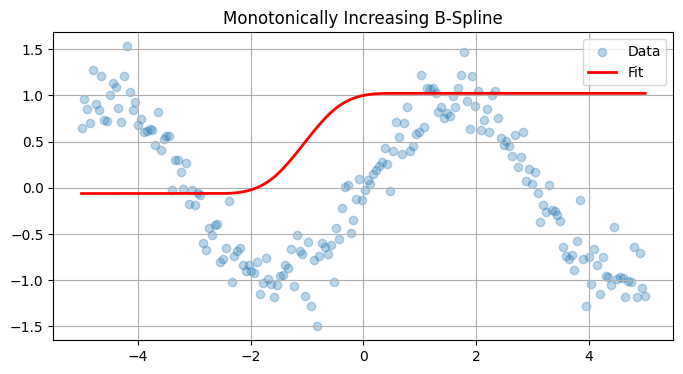

In [8]:


# Constrained (Increasing)
print("Monotonically Increasing B-Spline:")
opt_monot = +(
    BSpline("x", knots=np.linspace(-10, 10, 20), degree=3, tag='bs')
    .add_constraint(
        Monotonic(decreasing=False), 
        Anchor(xy=[(0, 1)]))
)

plot_fit(opt_monot, "Monotonically Increasing B-Spline")


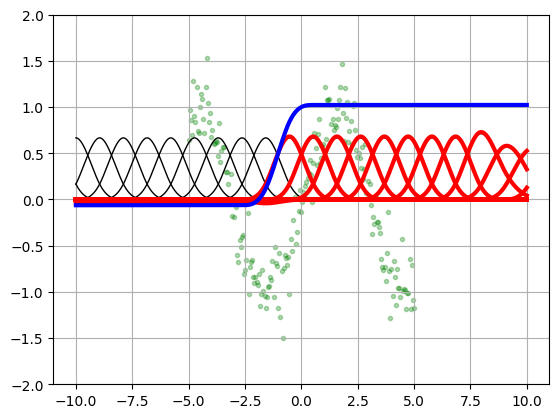

In [9]:
xx = np.linspace(-10, 10, 1000).reshape(-1, 1)
basis = opt_monot.get_spline('bs')._build_basis(xx)
evalbasis = opt_monot.get_spline('bs').eval(xx, return_basis=True)
evalspline = opt_monot.get_spline('bs').eval(xx, return_basis=False)

for i in range(basis.shape[1]):
    plt.plot(xx, basis[:, i], color='k', linewidth=1)
    plt.plot(xx, evalbasis[:, i], color='r', linewidth=3)
plt.scatter(df['x'], df['y'], color='green', alpha=.3, marker='.')
plt.plot(xx, evalspline, color='b', linewidth=3)
plt.ylim([-2, 2])
plt.grid()

In [11]:
opt_monot.get_spline('bs').coefficients

array([-0.06251264, -0.06247676, -0.062405  , -0.06229736, -0.06215384,
       -0.06215384, -0.06215383, -0.0621538 , -0.06215373, -0.06215363,
        1.02260007,  1.02259815,  1.02259451,  1.02259135,  1.02258911,
        1.02258806,  1.02258792,  1.02258792,  1.02281314,  1.02298206,
        1.02309466,  1.02315097])